In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
import copy

In [17]:
#Perceptron

In [2]:
# The dataset from scikit learn
wine = datasets.load_wine()
# Get input and output data from the dataset
X = wine.data
Y = wine.target
# Create new labels
Y = np.where(Y == 0, -1, Y)
Y = np.where(Y == 2, -1, Y)
# Let's get the number of features
d = X.shape[1]

In [3]:
##### Helper functions
def check_constraints(labels, all_possibile_labels, min_num_istances):
    # Count the number of occurrences using numpy
    unique, counts = np.unique(labels, return_counts=True)
    if len(all_possibile_labels) != len(unique):
        return True  #there are not all the labels
    if (counts >= min_num_istances).all():
        return False #there are enough istances of each label
    else:
        return True  #there are not enough istances of each label
    
def need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances):    #understands if the training and test are ok  
    return (check_constraints(y_train, all_possibile_labels, min_num_istances) or #train set not ok 
            check_constraints(y_test, all_possibile_labels, min_num_istances))    #test set not ok

In [4]:
def create_train_val_test_datasets(features : np.ndarray, labels: np.ndarray, m_t : int, m_test : int):
    
    df_perm = np.random.permutation(np.hstack((labels.reshape(np.size(labels), 1), features)))
    
    x_train = df_perm[0:m_t, 1:]
    y_train = df_perm[0:m_t, 0]
    
    x_test = df_perm[m_t:, 1:]
    y_test = df_perm[m_t:, 0]
    
    return x_train, y_train, x_test, y_test


def create_train_val_test_datasets_with_constraints(features : np.ndarray, labels: np.ndarray, m_t : int, 
                                                    m_test : int, min_num_istances : int):

    all_possibile_labels = np.unique(labels)
    
    x_train, y_train, x_test, y_test = create_train_val_test_datasets(features, labels, m_t, m_test)
    
    while(need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances)):
        x_train, y_train, x_test, y_test = create_train_val_test_datasets(features, labels, m_t, m_test)
    
    
    return x_train, y_train, x_test, y_test

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

In [5]:
assert x_train.shape[1] == d
assert x_test.shape[1] == d 

x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

In [6]:
def find_missclassified(X,Y,curr_w):
    
    missclassified_indeces = np.argwhere(Y * np.matmul(X, curr_w) <= 0)
    
    return missclassified_indeces.reshape(-1,)

def choose_missclassified(missclassified_indeces):
    
    if missclassified_indeces.size == 0:
        index = -1
    else:
        index = int(missclassified_indeces[0])
        
    return index

def perceptron(X,Y,max_num_iterations):
    #INITIALIZATION
    curr_w = np.zeros(X.shape[1])
    best_w = curr_w
    num_samples = X.shape[0]
    best_num_of_missclassified = num_samples+1;
    w_iters = []
    error_iters = []
    w_bestIters = []
    error_bestIters = []
    best_error = num_samples
    
    missclassified_indeces = find_missclassified(X, Y, curr_w)  
    num_missclassified = np.size(missclassified_indeces)       
    index_missclassified = choose_missclassified(missclassified_indeces)     

    
        
    num_iter = 1  
    while num_iter < max_num_iterations and index_missclassified != -1: 
        
        curr_w += Y[index_missclassified] * X[index_missclassified, :].T 
        
        missclassified_indeces = find_missclassified(X, Y, curr_w)
        index_missclassified = choose_missclassified(missclassified_indeces)
        num_missclassified = np.size(missclassified_indeces) # Remove this line
    
        if num_missclassified < best_num_of_missclassified:      
            best_w = copy.copy(curr_w) #вектор с коэффициентами лучшей модели
            best_num_of_missclassified = num_missclassified #доля неправильно классифицированных образцов для лучшей модели
            
            
            
        w_bestIters.append(copy.copy(best_w)) 
        error_bestIters.append(best_num_of_missclassified/num_samples)  
        w_iters.append(copy.copy(curr_w)) 
           
        error_iters.append(num_missclassified) 

        num_iter += 1 
        
        
    best_error = float(best_num_of_missclassified)/float(num_samples)    
    return best_w, best_error, w_bestIters, error_bestIters, w_iters, error_iters

In [7]:
index = choose_missclassified(np.array(list(range(100))))
assert type(index) == np.int64 or type(index) == int or type(index) == np.int32

In [8]:
w_found, training_error, _, _, _,_ = perceptron(x_train, y_train, 100)
print("Training error with 100 iterations: " + str(training_error))

Training error with 100 iterations: 0.1875


In [9]:
def classification_loss(y_target : np.ndarray, predictions : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples given two vectors: true labels and predictions. 
 
    '''
    missclassified_items = np.where(y_target != predictions, 1, 0)
    missclassified_number = np.sum(missclassified_items)
    missclassified_indeces = np.ones(missclassified_number)

    return missclassified_number / y_target.shape[0]


def compute_fraction_missclassified(X : np.ndarray, Y : np.ndarray, w : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    
    '''
    missclassified_samples = np.where(Y * np.matmul(X, w) < 0, 1, 0)
    fraction_missclass = np.sum(missclassified_samples) / X.shape[0]
    
    
    return fraction_missclass

In [10]:
assert classification_loss(np.array([[1],[3]]), np.array([[1],[3]])) == 0
assert classification_loss(np.array([[1],[2]]), np.array([[1],[3]])) == 0.5
y_labels, y_predictions = np.random.choice(10, 1000000), np.random.choice(10, 1000000)
assert np.isclose(classification_loss(y_labels, y_predictions), 0.9, atol=0.01)
assert training_error == compute_fraction_missclassified(x_train, y_train, w_found)

In [11]:
# now run the perceptron for 10000 iterations
w_found, training_error,w_listBest,error_list_trainBest,w_list, error_list_train = perceptron(x_train, y_train, 10000)
print(f"Training Error for 10000 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 10000 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 10000 iterations is 0.1500
Test Error for 10000 iterations is 0.2347


In [12]:
def error_models(X : np.ndarray, Y : np.ndarray, w_l : list) -> list:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    '''
    errors = []

    for w in w_l:
        errors.append(compute_fraction_missclassified(X, Y, w))
    return errors

Text(0.5, 1.0, 'Test Error using the w found at the current iteration')

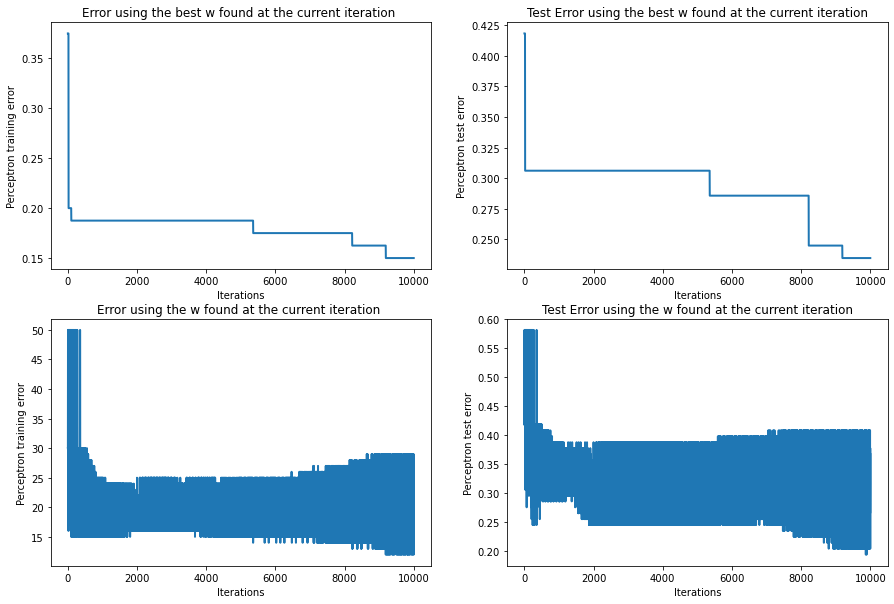

In [13]:
error_list_testBest = error_models(x_test, y_test, w_listBest)
error_list_test = error_models(x_test, y_test, w_list)
fig, axes = plt.subplots(2,2, figsize=(15,10))
axes[0][0].plot([i for i in range(len(w_listBest))], error_list_trainBest, linewidth=2)
axes[0][0].set_xlabel('Iterations')
axes[0][0].set_ylabel('Perceptron training error')
axes[0][0].set_title('Error using the best w found at the current iteration ')
axes[0][1].plot([i for i in range(len(w_list))], error_list_testBest, linewidth=2)
axes[0][1].set_xlabel('Iterations')
axes[0][1].set_ylabel('Perceptron test error')
axes[0][1].set_title('Test Error using the best w found at the current iteration')
axes[1][0].plot([i for i in range(len(w_list))], error_list_train, linewidth=2)
axes[1][0].set_xlabel('Iterations')
axes[1][0].set_ylabel('Perceptron training error')
axes[1][0].set_title('Error using the w found at the current iteration ')
axes[1][1].plot([i for i in range(len(w_list))], error_list_test, linewidth=2)
axes[1][1].set_xlabel('Iterations')
axes[1][1].set_ylabel('Perceptron test error')
axes[1][1].set_title('Test Error using the w found at the current iteration')

In [20]:
#Logistic Regression
# Now we use logistic regression, as implemented in Scikit-learn, to predict labels. 
# We first do it for 2 labels and then for 3 labels. 
# We will also plot the decision region of logistic regression.

In [21]:
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

In [22]:
# Logistic regression for 2 classes
# I compute the error rate (classification loss I will use the function "classification_loss" which I built before)
max_iter = 2000

logreg1 = linear_model.LogisticRegression(C = 1e5, max_iter = max_iter).fit(x_train, y_train)

error_rate_training = classification_loss(y_train, logreg1.predict(x_train))
error_rate_test = classification_loss(y_test, logreg1.predict(x_test))
error_rate_test_sklearn = 1 - logreg1.score(x_test, y_test)
    
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.16326530612244897
Compare the estimate of generalization with the sklearn implementation 0.16326530612244894


In [23]:
X = wine.data
Y = wine.target

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

_, counts = np.unique(y_train, return_counts=True)
assert (counts >= 20).all()
_, counts = np.unique(y_test, return_counts=True)
assert (counts >= 20).all()

In [24]:
# Logistic regression for 3 classes
# I compute the error rate (classification loss I will use the function "classification_loss" which I built before)
# Choose the proper number of iterations: max_iter.
max_iter = 2000


logreg2 = linear_model.LogisticRegression(C = 1e5, max_iter = max_iter).fit(x_train, y_train)

error_rate_training = classification_loss(y_train, logreg2.predict(x_train))
error_rate_test = classification_loss(y_test, logreg2.predict(x_test))
error_rate_test_sklearn = 1 - logreg2.score(x_test, y_test)
    
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.12244897959183673
Compare the estimate of generalization with the sklearn implementation 0.12244897959183676


In [25]:
#I make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                 'Proline']
labels_list = ['class_0', 'class_1', 'class_2']

index_feature1 = 0  
index_feature2 = 6  
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X = X[:,features]

# In the following I will keep the dataset with 3 classes
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

logreg = linear_model.LogisticRegression(C = 1e5, max_iter = max_iter).fit(x_train, y_train)

C:\Users\79663\AppData\Local\Temp/ipykernel_17732/1226924228.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
C:\Users\79663\AppData\Local\Temp/ipykernel_17732/1226924228.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


Text(0.5, 1.0, 'Test set')

<Figure size 288x216 with 0 Axes>

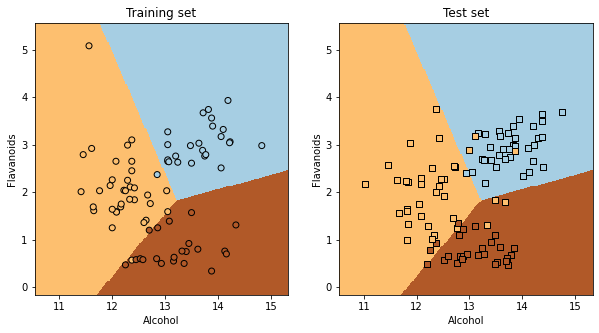

In [26]:
# Plot the decision boundary. For that, I will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
axes[0].set_xlabel(feature_name0)
axes[0].set_ylabel(feature_name1)

axes[0].set_xlim(xx.min(), xx.max())
axes[0].set_ylim(yy.min(), yy.max())
axes[0].set_title('Training set')

# Put the result into a color plot
Z = Z.reshape(xx.shape)
axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
axes[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
axes[1].set_xlabel(feature_name0)
axes[1].set_ylabel(feature_name1)

axes[1].set_xlim(xx.min(), xx.max())
axes[1].set_ylim(yy.min(), yy.max())
axes[1].set_title('Test set')